# Text mining with Python 
(following https://cienciadedatos.net/documentos/py25-text-mining-python)

### Libraries

In [2]:
# Basic
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Visualization
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocessing and modeling
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Warning
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

### Data

In [3]:
# Data adquisition
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/master/datos/'
tweets_elon   = pd.read_csv(url + "datos_tweets_@elonmusk.csv")
tweets_edlee  = pd.read_csv(url + "datos_tweets_@mayoredlee.csv")
tweets_bgates = pd.read_csv(url + "datos_tweets_@BillGates.csv")

print('Number of tweets @BillGates: ' + str(tweets_bgates.shape[0]))
print('Number of tweets @mayoredlee: ' + str(tweets_edlee.shape[0]))
print('Number of tweets @elonmusk: ' + str(tweets_elon.shape[0]))

Number of tweets @BillGates: 2087
Number of tweets @mayoredlee: 2447
Number of tweets @elonmusk: 2678


In [4]:
# One dataframe
tweets = pd.concat([tweets_elon, tweets_edlee, tweets_bgates], ignore_index=True)

# Columns of interest 
tweets = tweets[['screen_name', 'created_at', 'status_id', 'text']]
tweets.columns = ['autor', 'fecha', 'id', 'texto']

# Dates
tweets['fecha'] = pd.to_datetime(tweets['fecha'])
tweets.head(3)

,autor,fecha,id,texto
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,"""If one day, my words are against science, cho..."
1,elonmusk,2017-11-09 17:12:46+00:00,9.286717e+17,I placed the flowers\n\nThree broken ribs\nA p...
2,elonmusk,2017-11-08 18:55:13+00:00,9.283351e+17,Atatürk Anıtkabir https://t.co/al3wt0njr6


### Time distribution of tweets

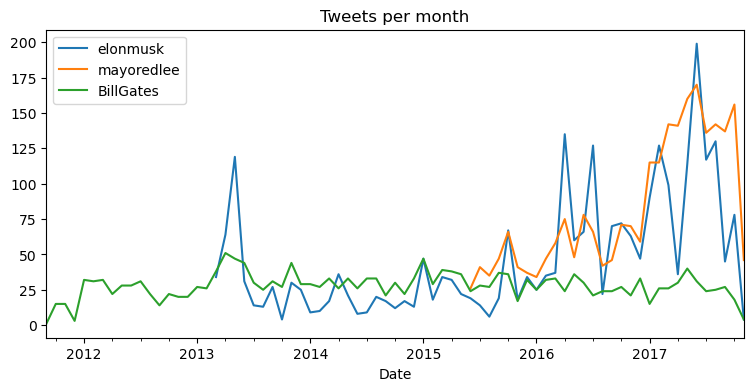

In [5]:
# Time distribution
# ==============================================================================
fig, ax = plt.subplots(figsize=(9,4))

for autor in tweets.autor.unique():
    df_temp = tweets[tweets['autor'] == autor].copy()
    df_temp['fecha'] = pd.to_datetime(df_temp['fecha'].dt.strftime('%Y-%m'))
    df_temp = df_temp.groupby(df_temp['fecha']).size()
    df_temp.plot(label=autor, ax=ax)

ax.set_title('Tweets per month')
ax.set_xlabel('Date')
ax.legend();

### Cleaning and tokenization

In [6]:
def clean_tokenize(text):
    '''
    This function cleans and tokenizes the text in individual words.
    The order of the text cleaning is not arbitrary.
    Punctuation marks list obtained from: print(string.punctuation)
    and re.escape(string.punctuation)
    '''
    
    # Text to lower case
    new_text = text.lower()
    # Web pages are deleted (starting with http)
    new_text = re.sub('http\S+', ' ', new_text)
    # Punctuation marks are deleted
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    new_text = re.sub(regex , ' ', new_text)
    # Numbers are deleted
    new_text = re.sub("\d+", ' ', new_text)
    # Multiple blank spaces are deleted
    new_text = re.sub("\\s+", ' ', new_text)
    # Tokenization into individual words
    new_text = new_text.split(sep = ' ')
    # Token with lenght < 2 are deleted
    new_text = [token for token in new_text if len(token) > 1]
    
    return(new_text)

test = "This is 1 example of6 TEXT c'cleaning https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(clean_tokenize(text=test))

This is 1 example of6 TEXT c'cleaning https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['this', 'is', 'example', 'of', 'text', 'cleaning', 'cienciadedatos', 'textmining']


In [7]:
# This function is applied to every tweet
# ==============================================================================
tweets['tokenized_text'] = tweets['texto'].apply(lambda x: clean_tokenize(x))
tweets[['texto', 'tokenized_text']].head()

,texto,tokenized_text
0,"""If one day, my words are against science, cho...","[if, one, day, my, words, are, against, scienc..."
1,I placed the flowers\n\nThree broken ribs\nA p...,"[placed, the, flowers, three, broken, ribs, pi..."
2,Atatürk Anıtkabir https://t.co/al3wt0njr6,"[atatürk, anıtkabir]"
3,"@Bob_Richards One rocket, slightly toasted","[bob, richards, one, rocket, slightly, toasted]"
4,@uncover007 500 ft so far. Should be 2 miles l...,"[uncover, ft, so, far, should, be, miles, long..."


## Exploratory analysis

In [8]:
# Unnest of tokenized_text
# ==============================================================================
tweets_tidy = tweets.explode(column='tokenized_text')
tweets_tidy = tweets_tidy.drop(columns='texto')
tweets_tidy = tweets_tidy.rename(columns={'tokenized_text':'token'})
tweets_tidy.head(3)

,autor,fecha,id,token
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,if
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,one
0,elonmusk,2017-11-09 17:28:57+00:00,9.286758e+17,day


### Word frequency

In [11]:
# Total words used per each author
# ==============================================================================
print('--------------------------')
print('Total words per author')
print('--------------------------')
tweets_tidy.groupby(by='autor')['token'].count()

--------------------------
Total words per author
--------------------------


autor
BillGates     31500
elonmusk      33609
mayoredlee    41878
Name: token, dtype: int64

In [12]:
# Different words used per each author
# ==============================================================================
print('----------------------------')
print('Different words per author')
print('----------------------------')
tweets_tidy.groupby(by='autor')['token'].nunique()

----------------------------
Different words per author
----------------------------


autor
BillGates     4848
elonmusk      6628
mayoredlee    5770
Name: token, dtype: int64

### Mean lenght of tweets

In [15]:
# Mean lenght and deviation of tweets grouped by author
# ==============================================================================
temp_df = pd.DataFrame(tweets_tidy.groupby(by = ["autor", "id"])["token"].count())
temp_df.reset_index().groupby("autor")["token"].agg(['mean', 'std'])

,mean,std
autor,,
BillGates,15.144231,3.347354
elonmusk,12.611257,6.933870
mayoredlee,17.170152,3.486314


### Most used words per author

In [18]:
# TOP 5 words most used per author
# ==============================================================================
tweets_tidy.groupby(['autor','token'])['token'] \
 .count() \
 .reset_index(name='count') \
 .groupby('autor') \
 .apply(lambda x: x.sort_values('count', ascending=False).head(5))

autor token  count
autor                                    
BillGates  4195    BillGates   the   1178
           4271    BillGates    to   1115
           2930    BillGates    of    669
           2084    BillGates    in    590
           2207    BillGates    is    452
elonmusk   10699    elonmusk   the    983
           10816    elonmusk    to    913
           8859     elonmusk    of    638
           7801     elonmusk    is    542
           7656     elonmusk    in    476
mayoredlee 16650  mayoredlee    to   1684
           16568  mayoredlee   the   1338
           11669  mayoredlee   amp   1212
           14957  mayoredlee   our   1096
           15964  mayoredlee    sf    909

### Stop words

In [20]:
# List of English stop words
# ==============================================================================
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))
# Stopwords added: amp, ax, ex
stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Manuel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [21]:
# Stop words are excluded
# ==============================================================================
tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]

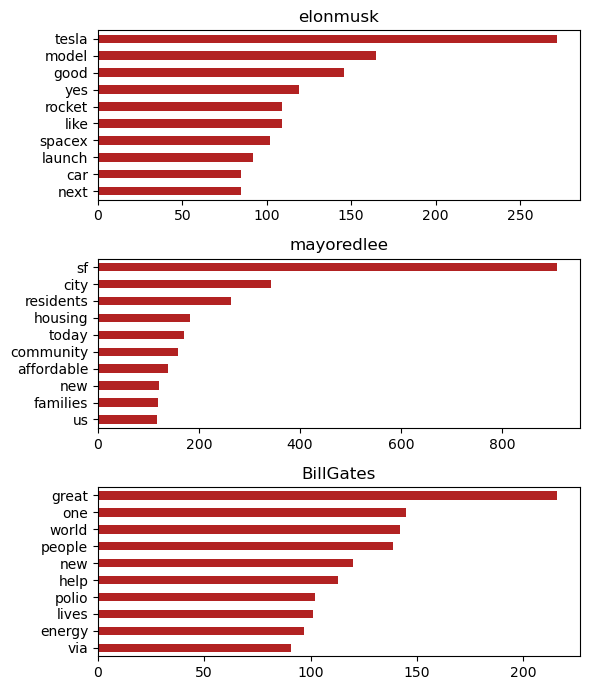

In [28]:
# TOP 10 words most used per author (without stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(6, 7))
for i, autor in enumerate(tweets_tidy.autor.unique()):
    df_temp = tweets_tidy[tweets_tidy.autor == autor]
    counts  = df_temp['token'].value_counts(ascending=False).head(10)
    counts.plot(kind='barh', color='firebrick', ax=axs[i])
    axs[i].invert_yaxis()
    axs[i].set_title(autor)

fig.tight_layout()

### Correlation between authors

In [29]:
# Pivot
# ==============================================================================
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")
tweets_pivot.columns.name = None


In [32]:
# Correlation test (cosine)
# ==============================================================================
from scipy.spatial.distance import cosine

def similarity_cosine(a,b):
    distance = cosine(a,b)
    return 1-distance

tweets_pivot.corr(method=similarity_cosine)

,BillGates,elonmusk,mayoredlee
BillGates,1.000000,0.567274,0.496346
elonmusk,0.567274,1.000000,0.276732
mayoredlee,0.496346,0.276732,1.000000


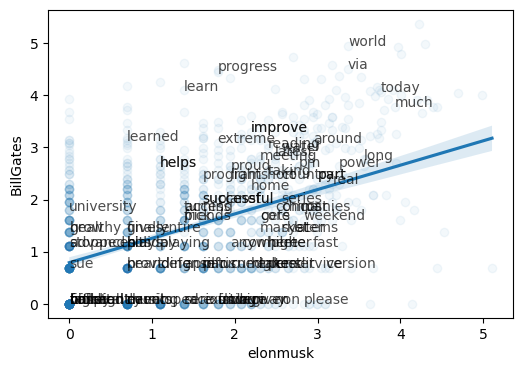

In [33]:
# Correlation plot
# ==============================================================================
f, ax = plt.subplots(figsize=(6, 4))
temp = tweets_pivot.dropna()
sns.regplot(
    x  = np.log(temp.elonmusk),
    y  = np.log(temp.BillGates),
    scatter_kws =  {'alpha': 0.05},
    ax = ax
);
for i in np.random.choice(range(temp.shape[0]), 100):
    ax.annotate(
        text  = temp.index[i],
        xy    = (np.log(temp.elonmusk[i]), np.log(temp.BillGates[i])),
        alpha = 0.7
    )

In [34]:
# Number of identical words
# ==============================================================================
words_elon = set(tweets_tidy[tweets_tidy.autor == 'elonmusk']['token'])
words_bill = set(tweets_tidy[tweets_tidy.autor == 'BillGates']['token'])
words_edlee = set(tweets_tidy[tweets_tidy.autor == 'mayoredlee']['token'])

print(f"Identical words between Elon Musk and Ed Lee: {len(words_elon.intersection(words_edlee))}")
print(f"Identical words between Elon Musk and Bill Gates: {len(words_elon.intersection(words_bill))}")

Identical words between Elon Musk and Ed Lee: 1760
Identical words between Elon Musk and Bill Gates: 1758


In [35]:
# Log of odds ratio (elonmusk vs mayoredlee)
# ==============================================================================
# Pivot and unpivot
tweets_pivot = tweets_tidy.groupby(["autor","token"])["token"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "token" , columns="autor", values= "count")

tweets_pivot = tweets_pivot.fillna(value=0)
tweets_pivot.columns.name = None

tweets_unpivot = tweets_pivot.melt(value_name='n', var_name='autor', ignore_index=False)
tweets_unpivot = tweets_unpivot.reset_index()

# Author selection
tweets_unpivot = tweets_unpivot[tweets_unpivot.autor.isin(['elonmusk', 'mayoredlee'])]

# Total number of words is added
tweets_unpivot = tweets_unpivot.merge(
                    tweets_tidy.groupby('autor')['token'].count().rename('N'),
                    how = 'left',
                    on  = 'autor'
                 )

# Odds and log of odds 
tweets_logOdds = tweets_unpivot.copy()
tweets_logOdds['odds'] = (tweets_logOdds.n + 1) / (tweets_logOdds.N + 1)
tweets_logOdds = tweets_logOdds[['token', 'autor', 'odds']] \
                    .pivot(index='token', columns='autor', values='odds')
tweets_logOdds.columns.name = None

tweets_logOdds['log_odds']     = np.log(tweets_logOdds.elonmusk/tweets_logOdds.mayoredlee)
tweets_logOdds['abs_log_odds'] = np.abs(tweets_logOdds.log_odds)

# if log of odds > 0, it means it is a word with
# greater probability of being from Musk. This is due to how the ratio is calculated
# elonmusk/mayoredlee.
tweets_logOdds['autor_frecuente'] = np.where(tweets_logOdds.log_odds > 0,
                                              "elonmusk",
                                              "mayoredlee"
                                    )

In [36]:
print('-----------------------------------')
print('Top 10 most different words')
print('-----------------------------------')
tweets_logOdds.sort_values('abs_log_odds', ascending=False).head(10)

-----------------------------------
Top 10 most different words
-----------------------------------


,elonmusk,mayoredlee,log_odds,abs_log_odds,autor_frecuente
token,,,,,
tesla,0.012569,0.000037,5.815040,5.815040,elonmusk
residents,0.000046,0.009934,-5.374162,5.374162,mayoredlee
yes,0.005525,0.000037,4.993060,4.993060,elonmusk
rocket,0.005064,0.000037,4.906049,4.906049,elonmusk
community,0.000046,0.005960,-4.863336,4.863336,mayoredlee
spacex,0.004742,0.000037,4.840297,4.840297,elonmusk
sf,0.000276,0.034112,-4.816117,4.816117,mayoredlee
falcon,0.003775,0.000037,4.612288,4.612288,elonmusk
landing,0.003039,0.000037,4.395223,4.395223,elonmusk


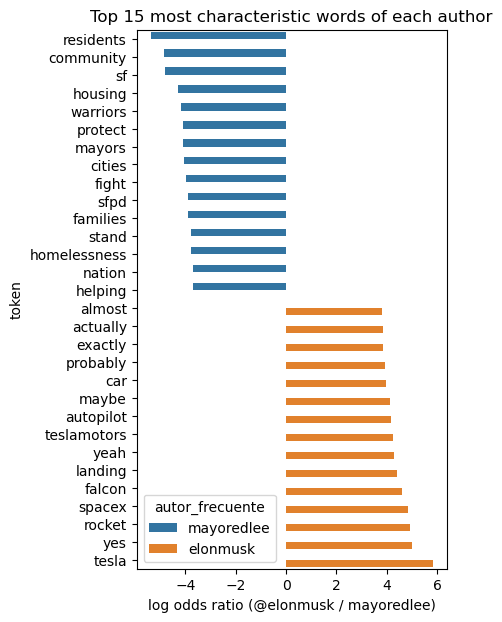

In [38]:
# Top 15 most characteristic words of each author
# ==============================================================================

top_30 = tweets_logOdds[['log_odds', 'abs_log_odds', 'autor_frecuente']] \
        .groupby('autor_frecuente') \
        .apply(lambda x: x.nlargest(15, columns='abs_log_odds').reset_index()) \
        .reset_index(drop=True) \
        .sort_values('log_odds')

f, ax = plt.subplots(figsize=(4, 7))
sns.barplot(
    x    = 'log_odds',
    y    = 'token',
    hue  = 'autor_frecuente',
    data = top_30,
    ax   = ax
)
ax.set_title('Top 15 most characteristic words of each author')
ax.set_xlabel('log odds ratio (@elonmusk / mayoredlee)');

## Term frequency and inverse document frequency

In [39]:
# Term-frecuency (tf)
# ==============================================================================
tf = tweets_tidy.copy()
# times term appears in each tweet
tf = tf.groupby(["id", "token"])["token"].agg(["count"]).reset_index()
# column added
tf['total_count'] = tf.groupby('id')['count'].transform(sum)
# tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(3)

,id,token,count,total_count,tf
8158,3.546906e+17,bar,1,20,0.05
8159,3.546906e+17,barman,1,20,0.05
8164,3.546906e+17,says,1,20,0.05


In [40]:
# Inverse document frequency
# ==============================================================================
idf = tweets_tidy.copy()
total_documents = idf["id"].drop_duplicates().count()
# Number of tweets 
idf = idf.groupby(["token", "id"])["token"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('token')['count'].transform(sum)
# idf
idf['idf'] = np.log(total_documents / idf['n_documentos'])
idf = idf[["token","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,token,n_documentos,idf
50471,sf,914,2.061781
8724,city,355,3.007494
22823,great,327,3.089651


In [41]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="token")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="id").head()

,id,token,count,total_count,tf,n_documentos,idf,tf_idf
0,1.195196e+17,efforts,1,13,0.076923,31,5.445624,0.418894
46,1.195196e+17,job,1,13,0.076923,36,5.296093,0.407392
229,1.195196e+17,nigeria,1,13,0.076923,10,6.577027,0.505925
239,1.195196e+17,phenomenal,1,13,0.076923,14,6.240554,0.480043
253,1.195196e+17,polio,1,13,0.076923,102,4.254639,0.327280


## Tweet classification

### Train-test

In [43]:
data_X = tweets.loc[tweets.autor.isin(['elonmusk', 'mayoredlee']), 'texto']
data_y = tweets.loc[tweets.autor.isin(['elonmusk', 'mayoredlee']), 'autor']

X_train, X_test, y_train, y_test = train_test_split(
    data_X,
    data_y,
    test_size = 0.2,
    random_state = 123  
)

In [44]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{'elonmusk': 52.68292682926829, 'mayoredlee': 47.31707317073171}
{'elonmusk': 50.53658536585366, 'mayoredlee': 49.46341463414634}


### Tf-idf Vectorizer

In [46]:
# tf-idf matrix
# ==============================================================================
tfidf_vectorizer = TfidfVectorizer(
                        tokenizer  = clean_tokenize,
                        min_df     = 3,
                        stop_words = stop_words
                    )
tfidf_vectorizer.fit(X_train)

TfidfVectorizer(min_df=3,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function clean_tokenize at 0x000001DA30C038B0>)

In [47]:
tfidf_train = tfidf_vectorizer.transform(X_train)
tfidf_test  = tfidf_vectorizer.transform(X_test)

In [49]:
print(f" Number of tokens: {len(tfidf_vectorizer.get_feature_names())}")
print(tfidf_vectorizer.get_feature_names()[:10])

 Number of tokens: 2738
['aa', 'aapi', 'aaronpaul', 'able', 'abort', 'abt', 'ac', 'aca', 'accel', 'acceleration']


### Linear SVM model

In [50]:
# SVM model training
# ==============================================================================
modelo_svm_linear = svm.SVC(kernel= "linear", C = 1.0)
modelo_svm_linear.fit(X=tfidf_train, y= y_train)

SVC(kernel='linear')

In [51]:
# Grid
# ==============================================================================
param_grid = {'C': np.logspace(-5, 3, 10)}

# Grid Search
# ==============================================================================
grid = GridSearchCV(
        estimator  = svm.SVC(kernel= "linear"),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = -1,
        cv         = 5, 
        verbose    = 0,
        return_train_score = True
      )

# 
_ = grid.fit(X = tfidf_train, y = y_train)

# Grid results
# ==============================================================================
results = pd.DataFrame(grid.cv_results_)
results.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_C,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.154435,0.967317,0.003123,0.997073,0.000366
5,0.278256,0.963902,0.001981,0.985244,0.000994
7,16.681005,0.959756,0.004154,0.998720,0.000122
8,129.154967,0.959024,0.005034,0.998780,0.000193
9,1000.0,0.959024,0.005034,0.998780,0.000193
4,0.035938,0.753902,0.013545,0.772683,0.006535
0,0.00001,0.526829,0.000000,0.526829,0.000000
1,0.000077,0.526829,0.000000,0.526829,0.000000
2,0.000599,0.526829,0.000000,0.526829,0.000000
3,0.004642,0.526829,0.000000,0.526829,0.000000


In [52]:
# Best hyperparameters CV
# ==============================================================================
print("----------------------------------------")
print("Best hyperparameters CV")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

modelo_final = grid.best_estimator_

----------------------------------------
Best hyperparameters CV
----------------------------------------
{'C': 2.154434690031882} : 0.9673170731707316 accuracy


In [54]:
# Error prediction test
# ==============================================================================
predictions_test = modelo_final.predict(X=tfidf_test)

print("-------------")
print("Test error")
print("-------------")

print(f"Number of failed classifications from a total of {tfidf_test.shape[0]} " \
      f"classifications: {(y_test != predictions_test).sum()}"
)
print(f"% error: {100*(y_test != predictions_test).mean()}")

print("")
print("-------------------")
print("Confusion matrix")
print("-------------------")
pd.DataFrame(confusion_matrix(y_true = y_test, y_pred= predictions_test),
             columns= ["Elon Musk", "Mayor Ed Lee"],
             index = ["Elon Musk", "Mayor Ed Lee"])

-------------
Test error
-------------
Number of failed classifications from a total of 1025 classifications: 21
% error: 2.048780487804878

-------------------
Confusion matrix
-------------------


,Elon Musk,Mayor Ed Lee
Elon Musk,512,6
Mayor Ed Lee,15,492


## Opinion analysis

In [55]:
# Lexicon 
# ==============================================================================
lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['term', 'opinion']
          )
lexicon.head()

,term,opinion
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [57]:
# Mean opinion of each tweet
# ==============================================================================
tweets_opinions = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token", 
                            right_on = "term",
                            how      = "inner"
                      )

tweets_opinions = tweets_opinions.drop(columns = "term")

# Sum of opinions
tweets_opinions = tweets_opinions[["autor","fecha", "id", "opinion"]] \
                      .groupby(["autor", "fecha", "id"])\
                      .sum().reset_index()
tweets_opinions.head()

,autor,fecha,id,opinion
0,BillGates,2011-09-29 21:11:15+00:00,1.195196e+17,6
1,BillGates,2011-10-04 19:06:05+00:00,1.213001e+17,-3
2,BillGates,2011-10-06 00:37:29+00:00,1.217459e+17,3
3,BillGates,2011-10-06 00:38:09+00:00,1.217460e+17,6
4,BillGates,2011-10-19 22:12:21+00:00,1.267828e+17,3


In [59]:
def opinions_profile(df):
    print(autor)
    print("=" * 12)
    print(f"Positives: {round(100 * np.mean(df.opinion > 0), 2)}")
    print(f"Neutral : {round(100 * np.mean(df.opinion == 0), 2)}")
    print(f"Negatives: {round(100 * np.mean(df.opinion < 0), 2)}")
    print(" ")

for autor, df in tweets_opinions.groupby("autor"):
    opinions_profile(df)

BillGates
Positives: 79.88
Neutral : 4.59
Negatives: 15.52
 
elonmusk
Positives: 73.14
Neutral : 4.29
Negatives: 22.57
 
mayoredlee
Positives: 80.73
Neutral : 4.07
Negatives: 15.2
 


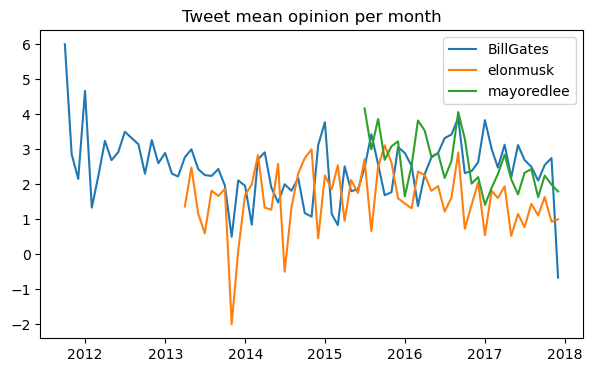

In [60]:
fig, ax = plt.subplots(figsize=(7, 4)) 

for autor in tweets_opinions.autor.unique():
    df = tweets_opinions[tweets_opinions.autor == autor].copy()
    df = df.set_index("fecha")
    df = df[['opinion']].resample('1M').mean()
    ax.plot(df.index, df.opinion, label=autor)

ax.set_title("Tweet mean opinion per month")
ax.legend();
